## Question 1

* CNN use fewer parameters and thus reduce overfitting.  
* CNN can detect the connection in spatial dimensions. 

## Question 2 

* In this case, there are (3 x 3 x 3 + 1) x 100 + (3 x 3 x 100 + 1) x 200 + (3 x 3 x 200 + 1) x 400 = 9,034,00 parameters.     
* Let's see the image size first. 
    * Input contain 200 x 300 pixels  
    * Layer 1 contain (200)/2 + 1 x (300)/2 = 100 x 150 pixels
        * The number of float32 is 100 x 150 x 100 x 4 Bytes = 6 MB
    * Layer 2 contain (100)/2 x (150)/2 = 50 x 75 pixels
        * The number of float32 is 50 x 75 x 200 x 4 Bytes = 3 MB 
    * Layer 3 contain (50)/2 x (75)/2 = 25 x 38 pixels
        * The number of float32 is 25 x 38 x 400 x 4 Bytes = 1.52 MB
    * Total for one instance is 6 + 3 + 1.52 = 10.52 MB
* Note that we need all of the computing value of all the layer at training state since it is needed for backpropagation. So, the minimum memory require is 10.52 MB + input image memory (0.7 MB) (we will ignore the backpropagation memory since it can also be release after the calculation is pass through that layer).
* We need 11.22 MB * 50 = 561 MB for 50 mini-batch.
    

## Question 3. 

* Try reducing the size of CNN by increasing the stride.  
* Run CNN on multiple computers.  
* Reduce mini-batch size.  
* Reduce tf.float32 to tf.float16

## Question 4. 

* Max pooling layer is faster to compute and it has no parameter to train.  
* It can, also, compress the graph while preserve the information.

## Question 5

* When you suspect that there are some feature map that exhibit strongly feature.

## Question 6

* Alexnet introduce the Local Response Normalizations

## Question 7

* The idea of FCN is to replace the dense layer with convolutional layer. The number of filter in this cnn have to be equal to number of neuron in the dense layer.  
    * In fact, the computation of such dense layer and cnn is the same.  
    * The only difference is that the FCN can implement to any size of images (but the number of channels have to be the same). 
    * This is the foundation of YOLO model.

## Question 8

* In the deeper layer of CNN, the size of the images is compressed. So, it hard to classify image based on original image pixels.

## Question 9

In [2]:
import tensorflow.keras.datasets as tfds

In [3]:
(x_train, y_train), (x_test, y_test) = tfds.mnist.load_data()

In [8]:
print(x_train.shape)
print(x_train.dtype)
print(x_train.min())
print(x_train.max())

print(y_train.shape)
print(y_train.dtype)
print(y_train.min())
print(y_train.max())

(60000, 28, 28)
uint8
0
255
(60000,)
uint8
0
9


In [9]:
x_train_scale = x_train/255.
x_test_scale = x_test/255.

In [10]:
# create basic CNN model
import tensorflow as tf
import tensorflow.keras as keras

In [35]:
class ExpandDimsLayer(keras.layers.Layer):
    def __init__(self, dtype = tf.float32, *args, **kwargs):
        super().__init__(dtype = dtype, *args, **kwargs)
    
    def call(self, inputs):
        return tf.expand_dims(inputs, axis = -1)

In [37]:
expand_dims = ExpandDimsLayer()
temp = tf.constant([1])
print(tf.shape(x_train[0]))
print(tf.shape(expand_dims(x_train[0])))

tf.Tensor([28 28], shape=(2,), dtype=int32)
tf.Tensor([28 28  1], shape=(3,), dtype=int32)


In [41]:
trainset = tf.data.Dataset.from_tensor_slices(x_train)

In [51]:
for data in trainset.take(1):
    print(tf.shape(data))
    print(tf.shape(expand_dims(data)))

tf.Tensor([28 28], shape=(2,), dtype=int32)
tf.Tensor([28 28  1], shape=(3,), dtype=int32)


In [38]:
keras.backend.clear_session()

model = keras.Sequential([
    keras.layers.Input(shape = [28, 28]),
    ExpandDimsLayer(),
    keras.layers.Conv2D(32, 3, activation = 'elu'),
    keras.layers.Conv2D(32, 3, activation = 'elu'),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(64, 3, activation = 'elu'),
    keras.layers.Conv2D(64, 3, activation = 'elu'),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(100, activation = 'elu'),
    keras.layers.Dense(10, activation = 'softmax')
])

model.compile(loss = 'sparse_categorical_crossentropy', metrics=['accuracy'], optimizer = keras.optimizers.Adam())

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
expand_dims_layer (ExpandDim (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 64)          0

In [40]:
model.fit(x_train_scale, y_train, epochs = 20, batch_size = 32, 
          validation_data=(x_test_scale, y_test), validation_batch_size=32)

Epoch 1/20
1875/1875 [==============================] - 171s 91ms/step - loss: 0.1158 - accuracy: 0.9640 - val_loss: 0.0808 - val_accuracy: 0.9763
Epoch 2/20
1875/1875 [==============================] - 201s 107ms/step - loss: 0.0519 - accuracy: 0.9848 - val_loss: 0.0448 - val_accuracy: 0.9857
Epoch 3/20
 661/1875 [=========>....................] - ETA: 2:14 - loss: 0.0342 - accuracy: 0.9890

KeyboardInterrupt: 

## Question 10

In [55]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

base_model2 = keras.applications.ResNet50(include_top=False)

94773248/94765736 [==============================] - 4s 0us/step


In [54]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [56]:
base_model2.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

### Create rescale layer to transform the image to the appropriate size of resnet

In [93]:
from tensorflow.image import grayscale_to_rgb
from tensorflow.image import resize

In [100]:
rgb_img = grayscale_to_rgb(expand_dims(tf.constant(x_train[0])))
rgb_img_resize = tf.cast(resize(rgb_img, size=(224, 224)), dtype=tf.uint8)

In [101]:
print(tf.reduce_max(rgb_img_resize))

tf.Tensor(253, shape=(), dtype=uint8)


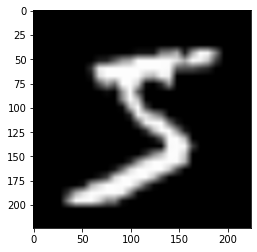

In [102]:
import matplotlib.pyplot as plt
plt.imshow(rgb_img_resize)
# plt.show()
# plt.imshow(x_train[0])

In [125]:
class PreprocessImageLayer(keras.layers.Layer):
    def __init__(self, *args, **kwargs):
        super().__init__(self, *args, **kwargs)
        
    def call(self, inputs):
        inputs = expand_dims(inputs)
        inputs = grayscale_to_rgb(inputs)
        inputs = tf.cast(resize(inputs, size=(224, 224)), dtype = tf.float32)
        return inputs/255.

In [126]:
preprocess = PreprocessImageLayer()

In [141]:
## create new model to transform image
keras.backend.clear_session()

inputs = keras.layers.Input(shape = [28, 28])
outputs = PreprocessImageLayer()(inputs)
outputs = base_model2(outputs)

my_model_a1 = keras.layers.GlobalAveragePooling2D()(outputs)
my_model_a2 = keras.layers.Dropout(0.25)(my_model_a1)
outputs = keras.layers.Dense(10, activation = 'softmax')(my_model_a2)

my_model = keras.models.Model(inputs = inputs, outputs = outputs)

for layer in base_model2.layers:
    layer.trainable = False
    
my_model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [142]:
my_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
preprocess_image_layer (Prep (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, None, None, 2048)  23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                20490     
Total params: 23,608,202
Trainable params: 20,490
Non-trainable params: 23,587,712
_____________________________________

In [143]:
my_model.fit(x_train, y_train, epochs = 2, validation_data=(x_test, y_test))

Epoch 1/2
  19/1875 [..............................] - ETA: 1:51:02 - loss: 2.4505 - accuracy: 0.1053

KeyboardInterrupt: 

**Training takes too long but it may be better**